In [118]:
import numpy as np
import pandas as pd

# create example data
data = pd.read_csv("rainfall_data.csv")
data=data.iloc[:,3:]
# calculate 95th percentile for each column
percentiles = data.quantile(0.95)

# find rows with values above the 95th percentile
above_95th = data[(data > percentiles).all(axis=1)]

print(above_95th)


       rainfall
6     24.932436
7     23.246956
41    33.846075
64    23.561225
83    22.738915
...         ...
2534  21.900691
2538  24.230811
2541  22.366934
2551  34.073259
2552  21.649361

[129 rows x 1 columns]


In [119]:
data = pd.read_csv("rainfall_data.csv")
# label extreme rows in original dataframe
data['rainfall_class'] = 'normal'
data.loc[data.index.isin(above_95th .index), 'rainfall_class'] = 'extreme'


In [120]:
extreme_data=data[data["rainfall_class"]=="extreme"]
normal_data=data[data["rainfall_class"]=="normal"]

In [121]:
import numpy as np
import copy
import tensorflow as tf
from sklearn import preprocessing
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from keras import backend as K
import os
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import seed
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import skfuzzy as fuzz
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


In [122]:
import pandas as pd
import numpy as np
data = pd.read_csv("rainfall_data.csv")
# label extreme rows in original dataframe
data['rainfall_class'] = 'normal'
data.loc[data.index.isin(above_95th .index), 'rainfall_class'] = 'extreme'

# Read in the sample data
df_extreme =data.copy()

# Set the "rainfall" values to null if the corresponding "rainfall_class" value is "extreme"
df_extreme.loc[df_extreme['rainfall_class'] == 'extreme', 'rainfall'] = np.nan


In [123]:
df_extreme[df_extreme["rainfall_class"]=="extreme"]

,date,windspeed,tpw,rainfall,rainfall_class
6,6/7/2000,21.163920,0.068528,NaN,extreme
7,6/8/2000,18.196522,0.028442,NaN,extreme
41,7/12/2000,23.003010,0.016358,NaN,extreme
64,8/4/2000,9.683878,0.028739,NaN,extreme
83,8/23/2000,20.520185,0.119045,NaN,extreme
...,...,...,...,...,...
2534,9/3/2020,5.484813,0.160226,NaN,extreme
2538,9/7/2020,6.730188,0.133245,NaN,extreme
2541,9/10/2020,12.099155,0.184418,NaN,extreme
2551,9/20/2020,18.062815,0.326716,NaN,extreme


In [124]:
data[data["rainfall_class"]=="extreme"]

,date,windspeed,tpw,rainfall,rainfall_class
6,6/7/2000,21.163920,0.068528,24.932436,extreme
7,6/8/2000,18.196522,0.028442,23.246956,extreme
41,7/12/2000,23.003010,0.016358,33.846075,extreme
64,8/4/2000,9.683878,0.028739,23.561225,extreme
83,8/23/2000,20.520185,0.119045,22.738915,extreme
...,...,...,...,...,...
2534,9/3/2020,5.484813,0.160226,21.900691,extreme
2538,9/7/2020,6.730188,0.133245,24.230811,extreme
2541,9/10/2020,12.099155,0.184418,22.366934,extreme
2551,9/20/2020,18.062815,0.326716,34.073259,extreme


In [125]:
df=data

In [126]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

def interpolate_missing_data(df, col_to_interpolate, cols_to_use, max_diffs):
    # Identify the missing data points in the specified column
    missing_indices = df[col_to_interpolate].isnull()
   
    # Loop through each missing data point
    for i in range(len(df)):
        if missing_indices[i]:
            # Find the nearby data points with valid values for the specified columns
            nearby_indices = (df[col_to_interpolate].notnull()) & \
                             (np.abs(df[cols_to_use[0]] - df.loc[i, cols_to_use[0]]) <= max_diffs) & \
                             (np.abs(df[cols_to_use[1]] - df.loc[i, cols_to_use[1]]) <= max_diffs)
            if sum(nearby_indices) < 2:
                continue
           
            # Use linear interpolation to estimate the missing value
            nearby_values = df.loc[nearby_indices, col_to_interpolate]
            nearby_cols = [df.loc[nearby_indices, col] for col in cols_to_use]
            slope = (nearby_values.iloc[1] - nearby_values.iloc[0]) / \
                    (nearby_cols[0].iloc[1] - nearby_cols[0].iloc[0])
            value_missing = nearby_values.iloc[0] + slope * (df.loc[i, cols_to_use[0]] - nearby_cols[0].iloc[0])
           
            # Fit a regression model to the residuals
            residuals = nearby_values - (nearby_cols[0] * slope + nearby_values.iloc[0])
            reg_model = LinearRegression()
            reg_model.fit(nearby_cols, residuals)
           
            # Use the regression model to adjust the estimated value
            adjustment = reg_model.predict(df.loc[i, cols_to_use].values.reshape(1, -1))
            value_missing += adjustment
           
            # Update the missing value in the DataFrame
            df.loc[i, col_to_interpolate] = value_missing
   
    return df


In [10]:
import pandas as pd
import numpy as np

# Read in the sample data

# Identify the missing data points in the "rainfall" column
missing_indices = df['rainfall'].isnull()

# Loop through each missing data point
for i in range(len(df)):
    if missing_indices[i]:
        # Find the two neighboring data points with valid rainfall values
        nearby_indices = (df['rainfall'].notnull()) & \
                         (np.abs(df['windspeed'] - df.loc[i, 'windspeed']) <= 30) & \
                         (np.abs(df['tpw'] - df.loc[i, 'tpw']) <= 0.2)
        if sum(nearby_indices) < 40:
            continue
        nearby_rainfall = df.loc[nearby_indices, 'rainfall']
        nearby_windspeed = df.loc[nearby_indices, 'windspeed']
        nearby_tpw = df.loc[nearby_indices, 'tpw']
        
        # Compute the slope between the two neighboring data points
        slope = (nearby_rainfall.iloc[1] - nearby_rainfall.iloc[0]) / \
                (nearby_windspeed.iloc[1] - nearby_windspeed.iloc[0])
        
        # Use the slope to estimate the rainfall value at the missing data point
        rainfall_missing = nearby_rainfall.iloc[0] + slope * \
                           (df.loc[i, 'windspeed'] - nearby_windspeed.iloc[0])
                           
        # Update the missing rainfall value in the dataframe
        df.loc[i, 'rainfall'] = rainfall_missing


In [127]:
 df_extreme.loc[(df_extreme['rainfall_class'] == 'extreme') & (df_extreme['rainfall'].isna())]


,date,windspeed,tpw,rainfall,rainfall_class
6,6/7/2000,21.163920,0.068528,NaN,extreme
7,6/8/2000,18.196522,0.028442,NaN,extreme
41,7/12/2000,23.003010,0.016358,NaN,extreme
64,8/4/2000,9.683878,0.028739,NaN,extreme
83,8/23/2000,20.520185,0.119045,NaN,extreme
...,...,...,...,...,...
2534,9/3/2020,5.484813,0.160226,NaN,extreme
2538,9/7/2020,6.730188,0.133245,NaN,extreme
2541,9/10/2020,12.099155,0.184418,NaN,extreme
2551,9/20/2020,18.062815,0.326716,NaN,extreme


In [22]:
import pandas as pd
import numpy as np

def interpolate_missing_data(df, col_to_interpolate, cols_to_use, max_diffs):
    # Identify the missing data points in the specified column
    missing_indices = df_extreme[col_to_interpolate].isnull()

    # Loop through each missing data point
    for i in range(len(df)):
        if missing_indices[i]:
            # Find the nearby data points with valid values for the specified columns
            nearby_indices = (df[col_to_interpolate].notnull()) & \
                             (np.abs(df[cols_to_use[0]] - df.loc[i, cols_to_use[0]]) <= max_diffs[0]) & \
                             (np.abs(df[cols_to_use[1]] - df.loc[i, cols_to_use[1]]) <= max_diffs[1])
            if sum(nearby_indices) < 2:
                continue
            nearby_values = df.loc[nearby_indices, col_to_interpolate]
            nearby_cols = [df.loc[nearby_indices, col] for col in cols_to_use]
            
            # Compute the slope between the two neighboring data points
            slope = (nearby_values.iloc[1] - nearby_values.iloc[0]) / \
                    (nearby_cols[0].iloc[1] - nearby_cols[0].iloc[0])
            
            # Use the slope to estimate the missing value
            value_missing = nearby_values.iloc[0] + slope + \
                            (df.loc[i, cols_to_use[0]] - nearby_cols[0].iloc[0])
                            
            # Update the missing value in the DataFrame
            df.loc[i, col_to_interpolate] = value_missing
            
    return df


In [128]:
df_inter= interpolate_missing_data(df, 'rainfall', ['windspeed', 'tpw'], [30, 0.3])


In [129]:
df_inter

,date,windspeed,tpw,rainfall,rainfall_class
0,6/1/2000,12.245595,0.033285,4.688589,normal
1,6/2/2000,12.825491,0.044874,11.330589,normal
2,6/3/2000,12.921664,0.010243,6.894713,normal
3,6/4/2000,15.149001,0.036881,4.613324,normal
4,6/5/2000,18.495907,0.139491,8.111635,normal
...,...,...,...,...,...
2557,9/26/2020,5.577215,0.009963,4.467977,normal
2558,9/27/2020,5.184293,0.002341,1.572182,normal
2559,9/28/2020,4.469007,0.000867,1.819019,normal
2560,9/29/2020,4.259090,0.001416,2.198017,normal


In [130]:
def weighted_loss(sparsity_weight=0.01, sparsity_target=0.001):
    def loss(y_true, y_pred):
        mse_loss = K.mean(K.square(abs(y_true[:,2] - y_pred[:,2])), axis=-1)
        kl_divergence = sparsity_weight * K.sum(sparsity_target * K.log(abs(sparsity_target / K.mean(abs(y_pred[:, 2])))) + abs((1 - sparsity_target)) * K.log(abs((1 - sparsity_target) / (1 - K.mean(abs(y_pred[:, 2]))))))
        return mse_loss + kl_divergence
    return loss


In [131]:

reg_strengths = [0.1, 1, 10, 100]
num_epochs = 5000
batch_size = 100
#train_data = normal_data[["windspeed_discretized","tpw_discretized"]].values.astype("float32")
train_data = normal_data[["windspeed","tpw","rainfall"]].values.astype("float32")

#best_reg_strength = find_best_reg_strength(train_data, reg_strengths, num_epochs, batch_size)

# Define the autoencoder architecture with the best regularization strength
input_layer = Input(shape=(3,),name='input')
encoded = Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(l2=20),name='encoder')(input_layer)
decoded = Dense(3, activation=None, name='decoder')(encoded)

# Create the autoencoder
autoencoder = Model(input_layer, decoded)

# Compile the autoencoder with the weighted loss function
#autoencoder.compile(optimizer='adam', loss="mse")
autoencoder.compile(optimizer='adam', loss=weighted_loss())

# Train the model with the majority class
history = autoencoder.fit(train_data, train_data, epochs=num_epochs, batch_size=batch_size, validation_split=0.2)
#history = autoencoder.fit(train_data,epochs=num_epochs, batch_size=batch_size, validation_split=0.2, verbose=0)


Epoch 1/5000
20/20 [==============================] - 2s 22ms/step - loss: 253.9513 - val_loss: 233.7097
Epoch 2/5000
20/20 [==============================] - 0s 5ms/step - loss: 221.5136 - val_loss: 204.4184
Epoch 3/5000
20/20 [==============================] - 0s 5ms/step - loss: 194.0812 - val_loss: 180.3911
Epoch 4/5000
20/20 [==============================] - 0s 4ms/step - loss: 172.0677 - val_loss: 160.8841
Epoch 5/5000
20/20 [==============================] - 0s 4ms/step - loss: 153.2716 - val_loss: 143.6192
Epoch 6/5000
20/20 [==============================] - 0s 5ms/step - loss: 136.5312 - val_loss: 128.3141
Epoch 7/5000
20/20 [==============================] - 0s 5ms/step - loss: 121.7180 - val_loss: 114.6588
Epoch 8/5000
20/20 [==============================] - 0s 5ms/step - loss: 108.5098 - val_loss: 102.4614
Epoch 9/5000
20/20 [==============================] - 0s 4ms/step - loss: 96.6988 - val_loss: 91.6719
Epoch 10/5000
20/20 [==============================] - 0s 5ms/ste

20/20 [==============================] - 0s 4ms/step - loss: 3.8918 - val_loss: 3.9967
Epoch 82/5000
20/20 [==============================] - 0s 4ms/step - loss: 3.8332 - val_loss: 3.9357
Epoch 83/5000
20/20 [==============================] - 0s 5ms/step - loss: 3.7760 - val_loss: 3.8794
Epoch 84/5000
20/20 [==============================] - 0s 5ms/step - loss: 3.7201 - val_loss: 3.8184
Epoch 85/5000
20/20 [==============================] - 0s 4ms/step - loss: 3.6657 - val_loss: 3.7592
Epoch 86/5000
20/20 [==============================] - 0s 4ms/step - loss: 3.6122 - val_loss: 3.6999
Epoch 87/5000
20/20 [==============================] - 0s 4ms/step - loss: 3.5604 - val_loss: 3.6473
Epoch 88/5000
20/20 [==============================] - 0s 4ms/step - loss: 3.5107 - val_loss: 3.5962
Epoch 89/5000
20/20 [==============================] - 0s 4ms/step - loss: 3.4632 - val_loss: 3.5428
Epoch 90/5000
20/20 [==============================] - 0s 4ms/step - loss: 3.4181 - val_loss: 3.4962
Epoc

20/20 [==============================] - 0s 4ms/step - loss: 1.6290 - val_loss: 1.6312
Epoch 162/5000
20/20 [==============================] - 0s 4ms/step - loss: 1.5945 - val_loss: 1.5730
Epoch 163/5000
20/20 [==============================] - 0s 4ms/step - loss: 1.5416 - val_loss: 1.5254
Epoch 164/5000
20/20 [==============================] - 0s 4ms/step - loss: 1.4981 - val_loss: 1.4857
Epoch 165/5000
20/20 [==============================] - 0s 4ms/step - loss: 1.4599 - val_loss: 1.4487
Epoch 166/5000
20/20 [==============================] - 0s 4ms/step - loss: 1.4261 - val_loss: 1.4132
Epoch 167/5000
20/20 [==============================] - 0s 4ms/step - loss: 1.3934 - val_loss: 1.3816
Epoch 168/5000
20/20 [==============================] - 0s 4ms/step - loss: 1.3649 - val_loss: 1.3549
Epoch 169/5000
20/20 [==============================] - 0s 4ms/step - loss: 1.3359 - val_loss: 1.3280
Epoch 170/5000
20/20 [==============================] - 0s 4ms/step - loss: 1.3095 - val_loss: 1.

20/20 [==============================] - 0s 4ms/step - loss: 0.4704 - val_loss: 0.4683
Epoch 242/5000
20/20 [==============================] - 0s 5ms/step - loss: 0.4675 - val_loss: 0.4643
Epoch 243/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.4627 - val_loss: 0.4591
Epoch 244/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.4578 - val_loss: 0.4543
Epoch 245/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.4530 - val_loss: 0.4501
Epoch 246/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.4502 - val_loss: 0.4477
Epoch 247/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.4463 - val_loss: 0.4437
Epoch 248/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.4421 - val_loss: 0.4383
Epoch 249/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.4386 - val_loss: 0.4353
Epoch 250/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.4335 - val_loss: 0.

20/20 [==============================] - 0s 4ms/step - loss: 0.2700 - val_loss: 0.2708
Epoch 322/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.2695 - val_loss: 0.2662
Epoch 323/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.2668 - val_loss: 0.2643
Epoch 324/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.2656 - val_loss: 0.2656
Epoch 325/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.2648 - val_loss: 0.2630
Epoch 326/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.2632 - val_loss: 0.2601
Epoch 327/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.2610 - val_loss: 0.2590
Epoch 328/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.2613 - val_loss: 0.2577
Epoch 329/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.2600 - val_loss: 0.2589
Epoch 330/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.2593 - val_loss: 0.

20/20 [==============================] - 0s 4ms/step - loss: 0.1859 - val_loss: 0.1858
Epoch 402/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.1847 - val_loss: 0.1838
Epoch 403/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.1848 - val_loss: 0.1847
Epoch 404/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.1841 - val_loss: 0.1824
Epoch 405/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.1835 - val_loss: 0.1836
Epoch 406/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.1827 - val_loss: 0.1816
Epoch 407/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.1811 - val_loss: 0.1801
Epoch 408/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.1804 - val_loss: 0.1799
Epoch 409/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.1800 - val_loss: 0.1791
Epoch 410/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.1789 - val_loss: 0.

20/20 [==============================] - 0s 4ms/step - loss: 0.1404 - val_loss: 0.1398
Epoch 482/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.1399 - val_loss: 0.1392
Epoch 483/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.1390 - val_loss: 0.1393
Epoch 484/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.1399 - val_loss: 0.1402
Epoch 485/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.1385 - val_loss: 0.1391
Epoch 486/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.1383 - val_loss: 0.1384
Epoch 487/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.1375 - val_loss: 0.1377
Epoch 488/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.1379 - val_loss: 0.1374
Epoch 489/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.1366 - val_loss: 0.1366
Epoch 490/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.1368 - val_loss: 0.

20/20 [==============================] - 0s 4ms/step - loss: 0.1133 - val_loss: 0.1134
Epoch 562/5000
20/20 [==============================] - 0s 5ms/step - loss: 0.1137 - val_loss: 0.1133
Epoch 563/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.1127 - val_loss: 0.1127
Epoch 564/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.1123 - val_loss: 0.1130
Epoch 565/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.1122 - val_loss: 0.1126
Epoch 566/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.1121 - val_loss: 0.1135
Epoch 567/5000
20/20 [==============================] - 0s 5ms/step - loss: 0.1117 - val_loss: 0.1117
Epoch 568/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.1120 - val_loss: 0.1119
Epoch 569/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.1116 - val_loss: 0.1127
Epoch 570/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.1115 - val_loss: 0.

20/20 [==============================] - 0s 4ms/step - loss: 0.0953 - val_loss: 0.0957
Epoch 642/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0956 - val_loss: 0.0956
Epoch 643/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0965 - val_loss: 0.0954
Epoch 644/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0962 - val_loss: 0.0953
Epoch 645/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0948 - val_loss: 0.0975
Epoch 646/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0985 - val_loss: 0.1002
Epoch 647/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0953 - val_loss: 0.0947
Epoch 648/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0942 - val_loss: 0.0945
Epoch 649/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0939 - val_loss: 0.0944
Epoch 650/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0942 - val_loss: 0.

20/20 [==============================] - 0s 4ms/step - loss: 0.0831 - val_loss: 0.0837
Epoch 722/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0832 - val_loss: 0.0835
Epoch 723/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0829 - val_loss: 0.0838
Epoch 724/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0831 - val_loss: 0.0832
Epoch 725/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0832 - val_loss: 0.0842
Epoch 726/5000
20/20 [==============================] - 0s 5ms/step - loss: 0.0836 - val_loss: 0.0832
Epoch 727/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0826 - val_loss: 0.0838
Epoch 728/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0825 - val_loss: 0.0834
Epoch 729/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0835 - val_loss: 0.0827
Epoch 730/5000
20/20 [==============================] - 0s 5ms/step - loss: 0.0824 - val_loss: 0.

20/20 [==============================] - 0s 4ms/step - loss: 0.0749 - val_loss: 0.0744
Epoch 802/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0741 - val_loss: 0.0769
Epoch 803/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0776 - val_loss: 0.0775
Epoch 804/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0759 - val_loss: 0.0789
Epoch 805/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0743 - val_loss: 0.0736
Epoch 806/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0731 - val_loss: 0.0737
Epoch 807/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0732 - val_loss: 0.0735
Epoch 808/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0731 - val_loss: 0.0733
Epoch 809/5000
20/20 [==============================] - 0s 5ms/step - loss: 0.0728 - val_loss: 0.0749
Epoch 810/5000
20/20 [==============================] - 0s 5ms/step - loss: 0.0735 - val_loss: 0.

20/20 [==============================] - 0s 4ms/step - loss: 0.0670 - val_loss: 0.0676
Epoch 882/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0669 - val_loss: 0.0668
Epoch 883/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0662 - val_loss: 0.0664
Epoch 884/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0665 - val_loss: 0.0665
Epoch 885/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0659 - val_loss: 0.0662
Epoch 886/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0665 - val_loss: 0.0662
Epoch 887/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0660 - val_loss: 0.0666
Epoch 888/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0657 - val_loss: 0.0669
Epoch 889/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0659 - val_loss: 0.0659
Epoch 890/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0659 - val_loss: 0.

20/20 [==============================] - 0s 5ms/step - loss: 0.0610 - val_loss: 0.0605
Epoch 962/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0603 - val_loss: 0.0606
Epoch 963/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0602 - val_loss: 0.0604
Epoch 964/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0600 - val_loss: 0.0603
Epoch 965/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0598 - val_loss: 0.0602
Epoch 966/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0598 - val_loss: 0.0602
Epoch 967/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0597 - val_loss: 0.0604
Epoch 968/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0597 - val_loss: 0.0601
Epoch 969/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0598 - val_loss: 0.0611
Epoch 970/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0598 - val_loss: 0.

20/20 [==============================] - 0s 4ms/step - loss: 0.0556 - val_loss: 0.0576
Epoch 1042/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0559 - val_loss: 0.0561
Epoch 1043/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0559 - val_loss: 0.0556
Epoch 1044/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0555 - val_loss: 0.0566
Epoch 1045/5000
20/20 [==============================] - 0s 5ms/step - loss: 0.0562 - val_loss: 0.0556
Epoch 1046/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0554 - val_loss: 0.0553
Epoch 1047/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0558 - val_loss: 0.0566
Epoch 1048/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0553 - val_loss: 0.0553
Epoch 1049/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0551 - val_loss: 0.0558
Epoch 1050/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0552 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0520 - val_loss: 0.0514
Epoch 1121/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0518 - val_loss: 0.0520
Epoch 1122/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0522 - val_loss: 0.0516
Epoch 1123/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0510 - val_loss: 0.0518
Epoch 1124/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0508 - val_loss: 0.0513
Epoch 1125/5000
20/20 [==============================] - 0s 5ms/step - loss: 0.0510 - val_loss: 0.0521
Epoch 1126/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0508 - val_loss: 0.0513
Epoch 1127/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0508 - val_loss: 0.0523
Epoch 1128/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0516 - val_loss: 0.0511
Epoch 1129/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0507 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0485 - val_loss: 0.0526
Epoch 1200/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0493 - val_loss: 0.0481
Epoch 1201/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0473 - val_loss: 0.0476
Epoch 1202/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0472 - val_loss: 0.0476
Epoch 1203/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0476 - val_loss: 0.0477
Epoch 1204/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0473 - val_loss: 0.0481
Epoch 1205/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0475 - val_loss: 0.0478
Epoch 1206/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0480 - val_loss: 0.0474
Epoch 1207/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0470 - val_loss: 0.0475
Epoch 1208/5000
20/20 [==============================] - 0s 5ms/step - loss: 0.0472 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0479 - val_loss: 0.0451
Epoch 1279/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0485 - val_loss: 0.0544
Epoch 1280/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0471 - val_loss: 0.0465
Epoch 1281/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0453 - val_loss: 0.0451
Epoch 1282/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0451 - val_loss: 0.0455
Epoch 1283/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0445 - val_loss: 0.0444
Epoch 1284/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0451 - val_loss: 0.0470
Epoch 1285/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0446 - val_loss: 0.0450
Epoch 1286/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0441 - val_loss: 0.0449
Epoch 1287/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0442 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0414 - val_loss: 0.0419
Epoch 1358/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0415 - val_loss: 0.0419
Epoch 1359/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0415 - val_loss: 0.0422
Epoch 1360/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0414 - val_loss: 0.0420
Epoch 1361/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0414 - val_loss: 0.0420
Epoch 1362/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0417 - val_loss: 0.0418
Epoch 1363/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0415 - val_loss: 0.0428
Epoch 1364/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0419 - val_loss: 0.0423
Epoch 1365/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0418 - val_loss: 0.0422
Epoch 1366/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0415 - val

20/20 [==============================] - 0s 6ms/step - loss: 0.0418 - val_loss: 0.0433
Epoch 1437/5000
20/20 [==============================] - 0s 5ms/step - loss: 0.0398 - val_loss: 0.0395
Epoch 1438/5000
20/20 [==============================] - 0s 5ms/step - loss: 0.0391 - val_loss: 0.0396
Epoch 1439/5000
20/20 [==============================] - 0s 5ms/step - loss: 0.0391 - val_loss: 0.0396
Epoch 1440/5000
20/20 [==============================] - 0s 6ms/step - loss: 0.0393 - val_loss: 0.0397
Epoch 1441/5000
20/20 [==============================] - 0s 5ms/step - loss: 0.0390 - val_loss: 0.0394
Epoch 1442/5000
20/20 [==============================] - 0s 5ms/step - loss: 0.0390 - val_loss: 0.0395
Epoch 1443/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0389 - val_loss: 0.0395
Epoch 1444/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0389 - val_loss: 0.0394
Epoch 1445/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0390 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0383 - val_loss: 0.0376
Epoch 1516/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0377 - val_loss: 0.0376
Epoch 1517/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0371 - val_loss: 0.0374
Epoch 1518/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0373 - val_loss: 0.0377
Epoch 1519/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0373 - val_loss: 0.0383
Epoch 1520/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0380 - val_loss: 0.0378
Epoch 1521/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0383 - val_loss: 0.0375
Epoch 1522/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0395 - val_loss: 0.0384
Epoch 1523/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0370 - val_loss: 0.0374
Epoch 1524/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0369 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0359 - val_loss: 0.0355
Epoch 1595/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0361 - val_loss: 0.0377
Epoch 1596/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0355 - val_loss: 0.0358
Epoch 1597/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0351 - val_loss: 0.0355
Epoch 1598/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0352 - val_loss: 0.0359
Epoch 1599/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0353 - val_loss: 0.0354
Epoch 1600/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0350 - val_loss: 0.0354
Epoch 1601/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0351 - val_loss: 0.0354
Epoch 1602/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0353 - val_loss: 0.0382
Epoch 1603/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0395 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0350 - val_loss: 0.0354
Epoch 1674/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0358 - val_loss: 0.0339
Epoch 1675/5000
20/20 [==============================] - 0s 6ms/step - loss: 0.0335 - val_loss: 0.0340
Epoch 1676/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0336 - val_loss: 0.0350
Epoch 1677/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0341 - val_loss: 0.0359
Epoch 1678/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0350 - val_loss: 0.0340
Epoch 1679/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0334 - val_loss: 0.0337
Epoch 1680/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0334 - val_loss: 0.0338
Epoch 1681/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0339 - val_loss: 0.0337
Epoch 1682/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0347 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0334 - val_loss: 0.0454
Epoch 1753/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0413 - val_loss: 0.0384
Epoch 1754/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0357 - val_loss: 0.0321
Epoch 1755/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0319 - val_loss: 0.0336
Epoch 1756/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0323 - val_loss: 0.0321
Epoch 1757/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0328 - val_loss: 0.0346
Epoch 1758/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0327 - val_loss: 0.0321
Epoch 1759/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0317 - val_loss: 0.0325
Epoch 1760/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0320 - val_loss: 0.0321
Epoch 1761/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0318 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0307 - val_loss: 0.0332
Epoch 1832/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0308 - val_loss: 0.0311
Epoch 1833/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0305 - val_loss: 0.0311
Epoch 1834/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0303 - val_loss: 0.0308
Epoch 1835/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0305 - val_loss: 0.0308
Epoch 1836/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0306 - val_loss: 0.0308
Epoch 1837/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0303 - val_loss: 0.0306
Epoch 1838/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0304 - val_loss: 0.0307
Epoch 1839/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0317 - val_loss: 0.0317
Epoch 1840/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0322 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0305 - val_loss: 0.0295
Epoch 1911/5000
20/20 [==============================] - 0s 5ms/step - loss: 0.0293 - val_loss: 0.0328
Epoch 1912/5000
20/20 [==============================] - 0s 5ms/step - loss: 0.0300 - val_loss: 0.0297
Epoch 1913/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0290 - val_loss: 0.0294
Epoch 1914/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0290 - val_loss: 0.0296
Epoch 1915/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0291 - val_loss: 0.0295
Epoch 1916/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0291 - val_loss: 0.0294
Epoch 1917/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0289 - val_loss: 0.0293
Epoch 1918/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0292 - val_loss: 0.0329
Epoch 1919/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0306 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0309 - val_loss: 0.0305
Epoch 1990/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0301 - val_loss: 0.0282
Epoch 1991/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0286 - val_loss: 0.0285
Epoch 1992/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0288 - val_loss: 0.0340
Epoch 1993/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0299 - val_loss: 0.0400
Epoch 1994/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0310 - val_loss: 0.0284
Epoch 1995/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0278 - val_loss: 0.0283
Epoch 1996/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0280 - val_loss: 0.0282
Epoch 1997/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0322 - val_loss: 0.0299
Epoch 1998/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0376 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0268 - val_loss: 0.0272
Epoch 2069/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0268 - val_loss: 0.0273
Epoch 2070/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0268 - val_loss: 0.0272
Epoch 2071/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0268 - val_loss: 0.0271
Epoch 2072/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0267 - val_loss: 0.0271
Epoch 2073/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0267 - val_loss: 0.0273
Epoch 2074/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0267 - val_loss: 0.0271
Epoch 2075/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0266 - val_loss: 0.0271
Epoch 2076/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0267 - val_loss: 0.0271
Epoch 2077/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0268 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0259 - val_loss: 0.0261
Epoch 2148/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0256 - val_loss: 0.0261
Epoch 2149/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0257 - val_loss: 0.0261
Epoch 2150/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0263 - val_loss: 0.0279
Epoch 2151/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0261 - val_loss: 0.0260
Epoch 2152/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0256 - val_loss: 0.0260
Epoch 2153/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0256 - val_loss: 0.0264
Epoch 2154/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0258 - val_loss: 0.0266
Epoch 2155/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0269 - val_loss: 0.0265
Epoch 2156/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0258 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0248 - val_loss: 0.0251
Epoch 2227/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0247 - val_loss: 0.0251
Epoch 2228/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0248 - val_loss: 0.0252
Epoch 2229/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0247 - val_loss: 0.0253
Epoch 2230/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0247 - val_loss: 0.0251
Epoch 2231/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0247 - val_loss: 0.0252
Epoch 2232/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0248 - val_loss: 0.0254
Epoch 2233/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0249 - val_loss: 0.0254
Epoch 2234/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0250 - val_loss: 0.0253
Epoch 2235/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0247 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0259 - val_loss: 0.0281
Epoch 2306/5000
20/20 [==============================] - 0s 5ms/step - loss: 0.0262 - val_loss: 0.0260
Epoch 2307/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0246 - val_loss: 0.0256
Epoch 2308/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0294 - val_loss: 0.0416
Epoch 2309/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0295 - val_loss: 0.0245
Epoch 2310/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0281 - val_loss: 0.0246
Epoch 2311/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0245 - val_loss: 0.0256
Epoch 2312/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0246 - val_loss: 0.0250
Epoch 2313/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0239 - val_loss: 0.0243
Epoch 2314/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0238 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0230 - val_loss: 0.0235
Epoch 2385/5000
20/20 [==============================] - 0s 5ms/step - loss: 0.0232 - val_loss: 0.0235
Epoch 2386/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0233 - val_loss: 0.0234
Epoch 2387/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0230 - val_loss: 0.0236
Epoch 2388/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0230 - val_loss: 0.0234
Epoch 2389/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0233 - val_loss: 0.0251
Epoch 2390/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0236 - val_loss: 0.0237
Epoch 2391/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0249 - val_loss: 0.0287
Epoch 2392/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0261 - val_loss: 0.0261
Epoch 2393/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0351 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0231 - val_loss: 0.0227
Epoch 2464/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0222 - val_loss: 0.0228
Epoch 2465/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0226 - val_loss: 0.0229
Epoch 2466/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0230 - val_loss: 0.0235
Epoch 2467/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0236 - val_loss: 0.0229
Epoch 2468/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0245 - val_loss: 0.0236
Epoch 2469/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0318 - val_loss: 0.0252
Epoch 2470/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0238 - val_loss: 0.0250
Epoch 2471/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0229 - val_loss: 0.0233
Epoch 2472/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0224 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0215 - val_loss: 0.0219
Epoch 2543/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0215 - val_loss: 0.0230
Epoch 2544/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0216 - val_loss: 0.0219
Epoch 2545/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0215 - val_loss: 0.0224
Epoch 2546/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0221 - val_loss: 0.0219
Epoch 2547/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0217 - val_loss: 0.0219
Epoch 2548/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0223 - val_loss: 0.0283
Epoch 2549/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0272 - val_loss: 0.0225
Epoch 2550/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0233 - val_loss: 0.0221
Epoch 2551/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0217 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0265 - val_loss: 0.0296
Epoch 2622/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0270 - val_loss: 0.0272
Epoch 2623/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0330 - val_loss: 0.0267
Epoch 2624/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0275 - val_loss: 0.0268
Epoch 2625/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0231 - val_loss: 0.0217
Epoch 2626/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0211 - val_loss: 0.0213
Epoch 2627/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0207 - val_loss: 0.0212
Epoch 2628/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0208 - val_loss: 0.0211
Epoch 2629/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0209 - val_loss: 0.0211
Epoch 2630/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0207 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0222 - val_loss: 0.0209
Epoch 2701/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0204 - val_loss: 0.0227
Epoch 2702/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0210 - val_loss: 0.0213
Epoch 2703/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0204 - val_loss: 0.0210
Epoch 2704/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0202 - val_loss: 0.0205
Epoch 2705/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0203 - val_loss: 0.0208
Epoch 2706/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0204 - val_loss: 0.0205
Epoch 2707/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0286 - val_loss: 0.0213
Epoch 2708/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0250 - val_loss: 0.0231
Epoch 2709/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0215 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0195 - val_loss: 0.0199
Epoch 2780/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0194 - val_loss: 0.0199
Epoch 2781/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0194 - val_loss: 0.0199
Epoch 2782/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0194 - val_loss: 0.0199
Epoch 2783/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0194 - val_loss: 0.0198
Epoch 2784/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0195 - val_loss: 0.0198
Epoch 2785/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0194 - val_loss: 0.0198
Epoch 2786/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0194 - val_loss: 0.0199
Epoch 2787/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0194 - val_loss: 0.0198
Epoch 2788/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0194 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0200 - val_loss: 0.0193
Epoch 2859/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0188 - val_loss: 0.0193
Epoch 2860/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0192 - val_loss: 0.0208
Epoch 2861/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0200 - val_loss: 0.0193
Epoch 2862/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0257 - val_loss: 0.0269
Epoch 2863/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0406 - val_loss: 0.0295
Epoch 2864/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0206 - val_loss: 0.0194
Epoch 2865/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0190 - val_loss: 0.0194
Epoch 2866/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0189 - val_loss: 0.0192
Epoch 2867/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0188 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0184 - val_loss: 0.0190
Epoch 2938/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0184 - val_loss: 0.0187
Epoch 2939/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0187 - val_loss: 0.0194
Epoch 2940/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0187 - val_loss: 0.0187
Epoch 2941/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0182 - val_loss: 0.0187
Epoch 2942/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0187 - val_loss: 0.0226
Epoch 2943/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0192 - val_loss: 0.0192
Epoch 2944/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0270 - val_loss: 0.1152
Epoch 2945/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0656 - val_loss: 0.0532
Epoch 2946/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0286 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0188 - val_loss: 0.0184
Epoch 3017/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0179 - val_loss: 0.0182
Epoch 3018/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0177 - val_loss: 0.0181
Epoch 3019/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0177 - val_loss: 0.0182
Epoch 3020/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0178 - val_loss: 0.0181
Epoch 3021/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0180 - val_loss: 0.0183
Epoch 3022/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0181 - val_loss: 0.0183
Epoch 3023/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0177 - val_loss: 0.0181
Epoch 3024/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0177 - val_loss: 0.0181
Epoch 3025/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0178 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0173 - val_loss: 0.0177
Epoch 3096/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0173 - val_loss: 0.0176
Epoch 3097/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0192 - val_loss: 0.0232
Epoch 3098/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0264 - val_loss: 0.0180
Epoch 3099/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0215 - val_loss: 0.0207
Epoch 3100/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0178 - val_loss: 0.0176
Epoch 3101/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0173 - val_loss: 0.0177
Epoch 3102/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0174 - val_loss: 0.0177
Epoch 3103/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0173 - val_loss: 0.0176
Epoch 3104/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0171 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0254 - val_loss: 0.0180
Epoch 3175/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0204 - val_loss: 0.0173
Epoch 3176/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0388 - val_loss: 0.0183
Epoch 3177/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0421 - val_loss: 0.0182
Epoch 3178/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0191 - val_loss: 0.0171
Epoch 3179/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0184 - val_loss: 0.0176
Epoch 3180/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0171 - val_loss: 0.0171
Epoch 3181/5000
20/20 [==============================] - 0s 5ms/step - loss: 0.0166 - val_loss: 0.0171
Epoch 3182/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0166 - val_loss: 0.0171
Epoch 3183/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0166 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0163 - val_loss: 0.0168
Epoch 3254/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0171 - val_loss: 0.0176
Epoch 3255/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0174 - val_loss: 0.0195
Epoch 3256/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0169 - val_loss: 0.0168
Epoch 3257/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0175 - val_loss: 0.0208
Epoch 3258/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0172 - val_loss: 0.0170
Epoch 3259/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0174 - val_loss: 0.0172
Epoch 3260/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0164 - val_loss: 0.0216
Epoch 3261/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0181 - val_loss: 0.0167
Epoch 3262/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0164 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0159 - val_loss: 0.0161
Epoch 3333/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0157 - val_loss: 0.0162
Epoch 3334/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0158 - val_loss: 0.0161
Epoch 3335/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0157 - val_loss: 0.0161
Epoch 3336/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0157 - val_loss: 0.0161
Epoch 3337/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0157 - val_loss: 0.0161
Epoch 3338/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0159 - val_loss: 0.0163
Epoch 3339/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0160 - val_loss: 0.0162
Epoch 3340/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0158 - val_loss: 0.0162
Epoch 3341/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0158 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0186 - val_loss: 0.0225
Epoch 3412/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0232 - val_loss: 0.0194
Epoch 3413/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0157 - val_loss: 0.0158
Epoch 3414/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0160 - val_loss: 0.0159
Epoch 3415/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0154 - val_loss: 0.0159
Epoch 3416/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0154 - val_loss: 0.0157
Epoch 3417/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0152 - val_loss: 0.0157
Epoch 3418/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0152 - val_loss: 0.0157
Epoch 3419/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0159 - val_loss: 0.0165
Epoch 3420/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0156 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0156 - val_loss: 0.0171
Epoch 3491/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0162 - val_loss: 0.0169
Epoch 3492/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0159 - val_loss: 0.0159
Epoch 3493/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0149 - val_loss: 0.0154
Epoch 3494/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0156 - val_loss: 0.0210
Epoch 3495/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0194 - val_loss: 0.0216
Epoch 3496/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0275 - val_loss: 0.0195
Epoch 3497/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0341 - val_loss: 0.0163
Epoch 3498/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0183 - val_loss: 0.0163
Epoch 3499/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0153 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0144 - val_loss: 0.0149
Epoch 3570/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0144 - val_loss: 0.0149
Epoch 3571/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0145 - val_loss: 0.0149
Epoch 3572/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0145 - val_loss: 0.0149
Epoch 3573/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0147 - val_loss: 0.0149
Epoch 3574/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0145 - val_loss: 0.0158
Epoch 3575/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0157 - val_loss: 0.0165
Epoch 3576/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0157 - val_loss: 0.0157
Epoch 3577/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0145 - val_loss: 0.0149
Epoch 3578/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0146 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0145 - val_loss: 0.0148
Epoch 3649/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0180 - val_loss: 0.0250
Epoch 3650/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0166 - val_loss: 0.0157
Epoch 3651/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0190 - val_loss: 0.0152
Epoch 3652/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0322 - val_loss: 0.0920
Epoch 3653/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0334 - val_loss: 0.0150
Epoch 3654/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0163 - val_loss: 0.0172
Epoch 3655/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0146 - val_loss: 0.0145
Epoch 3656/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0142 - val_loss: 0.0145
Epoch 3657/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0140 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0204 - val_loss: 0.0147
Epoch 3728/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0164 - val_loss: 0.0255
Epoch 3729/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0184 - val_loss: 0.0161
Epoch 3730/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0150 - val_loss: 0.0141
Epoch 3731/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0141 - val_loss: 0.0161
Epoch 3732/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0148 - val_loss: 0.0141
Epoch 3733/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0155 - val_loss: 0.0159
Epoch 3734/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0141 - val_loss: 0.0154
Epoch 3735/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0154 - val_loss: 0.0201
Epoch 3736/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0157 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0184 - val_loss: 0.0201
Epoch 3807/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0165 - val_loss: 0.0137
Epoch 3808/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0154 - val_loss: 0.0199
Epoch 3809/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0157 - val_loss: 0.0137
Epoch 3810/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0138 - val_loss: 0.0153
Epoch 3811/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0138 - val_loss: 0.0161
Epoch 3812/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0138 - val_loss: 0.0140
Epoch 3813/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0139 - val_loss: 0.0144
Epoch 3814/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0168 - val_loss: 0.0210
Epoch 3815/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0181 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0135 - val_loss: 0.0136
Epoch 3886/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0130 - val_loss: 0.0134
Epoch 3887/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0131 - val_loss: 0.0138
Epoch 3888/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0134 - val_loss: 0.0134
Epoch 3889/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0138 - val_loss: 0.0136
Epoch 3890/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0204 - val_loss: 0.1093
Epoch 3891/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0455 - val_loss: 0.0138
Epoch 3892/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0205 - val_loss: 0.0161
Epoch 3893/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0136 - val_loss: 0.0134
Epoch 3894/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0133 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0127 - val_loss: 0.0132
Epoch 3965/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0126 - val_loss: 0.0130
Epoch 3966/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0126 - val_loss: 0.0130
Epoch 3967/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0129 - val_loss: 0.0134
Epoch 3968/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0128 - val_loss: 0.0149
Epoch 3969/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0169 - val_loss: 0.0138
Epoch 3970/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0142 - val_loss: 0.0133
Epoch 3971/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0130 - val_loss: 0.0134
Epoch 3972/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0126 - val_loss: 0.0131
Epoch 3973/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0127 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0128 - val_loss: 0.0129
Epoch 4044/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0124 - val_loss: 0.0128
Epoch 4045/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0123 - val_loss: 0.0127
Epoch 4046/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0124 - val_loss: 0.0128
Epoch 4047/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0123 - val_loss: 0.0127
Epoch 4048/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0122 - val_loss: 0.0128
Epoch 4049/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0123 - val_loss: 0.0127
Epoch 4050/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0123 - val_loss: 0.0127
Epoch 4051/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0122 - val_loss: 0.0128
Epoch 4052/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0123 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0144 - val_loss: 0.0142
Epoch 4123/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0126 - val_loss: 0.0124
Epoch 4124/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0122 - val_loss: 0.0125
Epoch 4125/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0124 - val_loss: 0.0128
Epoch 4126/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0131 - val_loss: 0.0177
Epoch 4127/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0136 - val_loss: 0.0204
Epoch 4128/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0155 - val_loss: 0.0139
Epoch 4129/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0192 - val_loss: 0.0284
Epoch 4130/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0168 - val_loss: 0.0169
Epoch 4131/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0136 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0119 - val_loss: 0.0122
Epoch 4202/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0119 - val_loss: 0.0123
Epoch 4203/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0119 - val_loss: 0.0124
Epoch 4204/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0118 - val_loss: 0.0122
Epoch 4205/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0117 - val_loss: 0.0121
Epoch 4206/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0117 - val_loss: 0.0122
Epoch 4207/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0117 - val_loss: 0.0121
Epoch 4208/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0119 - val_loss: 0.0126
Epoch 4209/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0127 - val_loss: 0.0121
Epoch 4210/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0124 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0114 - val_loss: 0.0118
Epoch 4281/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0113 - val_loss: 0.0118
Epoch 4282/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0113 - val_loss: 0.0118
Epoch 4283/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0113 - val_loss: 0.0118
Epoch 4284/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0115 - val_loss: 0.0118
Epoch 4285/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0113 - val_loss: 0.0118
Epoch 4286/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0116 - val_loss: 0.0120
Epoch 4287/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0131 - val_loss: 0.0181
Epoch 4288/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0321 - val_loss: 0.0289
Epoch 4289/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0153 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0111 - val_loss: 0.0117
Epoch 4360/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0113 - val_loss: 0.0116
Epoch 4361/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0111 - val_loss: 0.0115
Epoch 4362/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0117 - val_loss: 0.0121
Epoch 4363/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0116 - val_loss: 0.0116
Epoch 4364/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0116 - val_loss: 0.0119
Epoch 4365/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0114 - val_loss: 0.0122
Epoch 4366/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0111 - val_loss: 0.0115
Epoch 4367/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0110 - val_loss: 0.0116
Epoch 4368/5000
20/20 [==============================] - 0s 5ms/step - loss: 0.0115 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0108 - val_loss: 0.0113
Epoch 4439/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0123 - val_loss: 0.0119
Epoch 4440/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0122 - val_loss: 0.0114
Epoch 4441/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 4442/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0117 - val_loss: 0.0112
Epoch 4443/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0116 - val_loss: 0.0112
Epoch 4444/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0109 - val_loss: 0.0115
Epoch 4445/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0110 - val_loss: 0.0113
Epoch 4446/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0108 - val_loss: 0.0112
Epoch 4447/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0119 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0106 - val_loss: 0.0109
Epoch 4518/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0105 - val_loss: 0.0109
Epoch 4519/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0105 - val_loss: 0.0110
Epoch 4520/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0105 - val_loss: 0.0109
Epoch 4521/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0106 - val_loss: 0.0110
Epoch 4522/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0107 - val_loss: 0.0111
Epoch 4523/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0106 - val_loss: 0.0110
Epoch 4524/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0105 - val_loss: 0.0112
Epoch 4525/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0105 - val_loss: 0.0109
Epoch 4526/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0104 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0104 - val_loss: 0.0107
Epoch 4597/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0103 - val_loss: 0.0107
Epoch 4598/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0103 - val_loss: 0.0107
Epoch 4599/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0104 - val_loss: 0.0114
Epoch 4600/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0108 - val_loss: 0.0109
Epoch 4601/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0105 - val_loss: 0.0111
Epoch 4602/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0106 - val_loss: 0.0116
Epoch 4603/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0107 - val_loss: 0.0112
Epoch 4604/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0108 - val_loss: 0.0111
Epoch 4605/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0104 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0150 - val_loss: 0.0107
Epoch 4676/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0107 - val_loss: 0.0105
Epoch 4677/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0100 - val_loss: 0.0106
Epoch 4678/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0100 - val_loss: 0.0104
Epoch 4679/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0100 - val_loss: 0.0104
Epoch 4680/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0100 - val_loss: 0.0104
Epoch 4681/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0100 - val_loss: 0.0104
Epoch 4682/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0100 - val_loss: 0.0104
Epoch 4683/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0100 - val_loss: 0.0105
Epoch 4684/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0101 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0101 - val_loss: 0.0104
Epoch 4755/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0098 - val_loss: 0.0102
Epoch 4756/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0097 - val_loss: 0.0102
Epoch 4757/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0099 - val_loss: 0.0117
Epoch 4758/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0105 - val_loss: 0.0119
Epoch 4759/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0158 - val_loss: 0.0134
Epoch 4760/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0182 - val_loss: 0.0172
Epoch 4761/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0137 - val_loss: 0.0110
Epoch 4762/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0119 - val_loss: 0.0117
Epoch 4763/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0117 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0096 - val_loss: 0.0100
Epoch 4834/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0096 - val_loss: 0.0100
Epoch 4835/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0095 - val_loss: 0.0099
Epoch 4836/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0095 - val_loss: 0.0100
Epoch 4837/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0095 - val_loss: 0.0101
Epoch 4838/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0096 - val_loss: 0.0100
Epoch 4839/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0097 - val_loss: 0.0104
Epoch 4840/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0097 - val_loss: 0.0099
Epoch 4841/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0095 - val_loss: 0.0099
Epoch 4842/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0095 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0094 - val_loss: 0.0097
Epoch 4913/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0093 - val_loss: 0.0097
Epoch 4914/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0093 - val_loss: 0.0102
Epoch 4915/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0096 - val_loss: 0.0097
Epoch 4916/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0100 - val_loss: 0.0154
Epoch 4917/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0184 - val_loss: 0.0187
Epoch 4918/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0124 - val_loss: 0.0366
Epoch 4919/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0172 - val_loss: 0.0115
Epoch 4920/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0103 - val_loss: 0.0097
Epoch 4921/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0093 - val

20/20 [==============================] - 0s 4ms/step - loss: 0.0094 - val_loss: 0.0096
Epoch 4992/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0094 - val_loss: 0.0109
Epoch 4993/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0115 - val_loss: 0.0149
Epoch 4994/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0115 - val_loss: 0.0095
Epoch 4995/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0092 - val_loss: 0.0098
Epoch 4996/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0095 - val_loss: 0.0099
Epoch 4997/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0103 - val_loss: 0.0130
Epoch 4998/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0145 - val_loss: 0.0136
Epoch 4999/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0132 - val_loss: 0.0242
Epoch 5000/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.0108 - val

In [132]:
#test_data = data[["windspeed_discretized","tpw_discretized","rainfall_discretized"]].values
test_data = df_inter[["windspeed","tpw","rainfall"]].values
#autoencoder = load_model("my_autoencoder_model.h5", custom_objects={"loss": weighted_loss()})

predicted_data = autoencoder.predict(test_data)

81/81 [==============================] - 0s 1ms/step


In [133]:
predicted_data

array([[-0.42845935,  1.4172997 ,  4.684903  ],
       [-0.51715255,  1.4041874 , 11.312889  ],
       [-0.45793194,  1.4129487 ,  6.8864975 ],
       ...,
       [-0.38996732,  1.4229081 ,  1.8195696 ],
       [-0.3950224 ,  1.422158  ,  2.1977088 ],
       [-0.5354502 ,  1.4014014 , 12.691221  ]], dtype=float32)

In [145]:
data['predicted_rainfall'] = predicted_data[:, 2]

# Calculate the error between the predicted and actual rainfall values
data['error'] = abs(abs(data['predicted_rainfall']) - abs(data['rainfall']))

In [146]:
data["error"]

0       0.003686
1       0.017700
2       0.008216
3       0.002820
4       0.009489
          ...   
2557    0.004828
2558    0.001249
2559    0.000551
2560    0.000308
2561    0.022413
Name: error, Length: 2562, dtype: float64

In [147]:
mean_error = np.mean(data['error'])
threshold = mean_error
print(threshold)

data['rainfall_class'] = np.where(data['error'] > threshold, 'Extreme', 'Normal')
# Define the actual rainfall class based on the threshold of 11
data['actual_rainfall_class'] = np.where(data['rainfall'] >20.807473 , 'Extreme', 'Normal')


0.20024774243987184


In [148]:
def find_roc_curve():
    data['actual_rainfall_binary'] = (data['rainfall_class'] == 'Extreme') & (data['actual_rainfall_class'] == 'Extreme')

    fpr, tpr, thresholds = roc_curve(data['actual_rainfall_binary'], data['error'])
    roc_auc = auc(fpr, tpr)
    # Calculate TNR
    tnr = 1 - fpr

    # Calculate Youden's J statistic for each threshold
    j_stat = tpr + tnr - 1

    # Find the index of the threshold that maximizes J
    best_threshold_idx = np.argmax(j_stat)

    # Get the best threshold
    best_threshold = thresholds[best_threshold_idx]
    threshold=round(best_threshold , 1)
    return threshold

In [149]:

threshold=(find_roc_curve())
print(threshold)

0.2


In [150]:
data

,date,windspeed,tpw,rainfall,rainfall_class,predicted_rainfall,error,actual_rainfall_class,actual_rainfall_binary
0,6/1/2000,12.245595,0.033285,4.688589,Normal,4.684903,0.003686,Normal,False
1,6/2/2000,12.825491,0.044874,11.330589,Normal,11.312889,0.017700,Normal,False
2,6/3/2000,12.921664,0.010243,6.894713,Normal,6.886497,0.008216,Normal,False
3,6/4/2000,15.149001,0.036881,4.613324,Normal,4.610504,0.002820,Normal,False
4,6/5/2000,18.495907,0.139491,8.111635,Normal,8.102146,0.009489,Normal,False
...,...,...,...,...,...,...,...,...,...
2557,9/26/2020,5.577215,0.009963,4.467977,Normal,4.463149,0.004828,Normal,False
2558,9/27/2020,5.184293,0.002341,1.572182,Normal,1.573431,0.001249,Normal,False
2559,9/28/2020,4.469007,0.000867,1.819019,Normal,1.819570,0.000551,Normal,False
2560,9/29/2020,4.259090,0.001416,2.198017,Normal,2.197709,0.000308,Normal,False


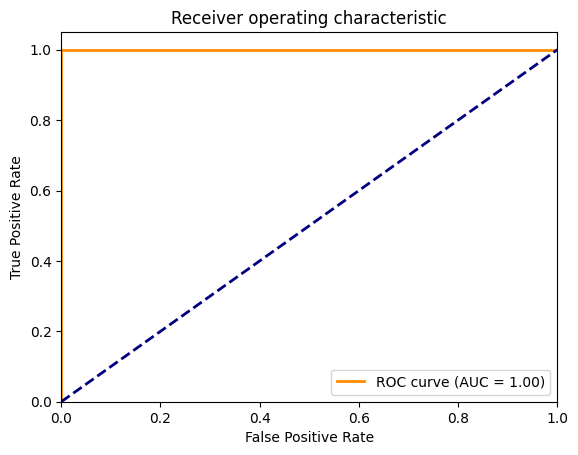

Best threshold: 0.20782515728515705


In [151]:
# Create a binary column indicating whether the actual rainfall was Extreme or not
data['actual_rainfall_binary'] = (data['rainfall_class'] == 'Extreme') & (data['actual_rainfall_class'] == 'Extreme')
# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(data['actual_rainfall_binary'], data['error'])
roc_auc = auc(fpr, tpr)
# Calculate TNR
tnr = 1 - fpr

# Calculate Youden's J statistic for each threshold
j_stat = tpr + tnr - 1

# Find the index of the threshold that maximizes J
best_threshold_idx = np.argmax(j_stat)

# Get the best threshold
best_threshold = thresholds[best_threshold_idx]

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


# Print the best threshold
print("Best threshold:", best_threshold)

In [152]:
data['rainfall_class'] = np.where(data['error'] > threshold, 'Extreme', 'Normal')


In [153]:
# Define the actual rainfall class based on the threshold of 11
data['actual_rainfall_class'] = np.where(data['rainfall'] >20.807473 , 'Extreme', 'Normal')


# Calculate the accuracy
num_correct = len(data[data['rainfall_class'] == data['actual_rainfall_class']])
num_total = len(data)
accuracy = num_correct / num_total * 100
print('Accuracy: {:.2f}%'.format(accuracy))


Accuracy: 98.87%


In [154]:
wrong_predictions = data[data['rainfall_class'] != data['actual_rainfall_class']]

# Print the wrong predictions
print(wrong_predictions.count())

date                      29
windspeed                 29
tpw                       29
rainfall                  29
rainfall_class            29
predicted_rainfall        29
error                     29
actual_rainfall_class     29
actual_rainfall_binary    29
dtype: int64


In [70]:
df_inter.loc[df['rainfall_class'] == 'normal']

,date,windspeed,tpw,rainfall,rainfall_class,predicted_rainfall,error,actual_rainfall_class,actual_rainfall_binary


In [15]:
df.loc[(df['rainfall_class'] == 'extreme') & (df['rainfall'].isna())]


,date,windspeed,tpw,rainfall,rainfall_class


In [16]:
new_data = pd.read_csv("rainfall_data.csv")
# label extreme rows in original dataframe
new_data['rainfall_class'] = 'normal'
new_data.loc[new_data.index.isin(above_95th .index), 'rainfall_class'] = 'extreme'


In [17]:
# Create a new DataFrame containing only the extreme cases from the original DataFrame
extreme_cases_df = df_inter[df_inter['rainfall_class'] == 'extreme'][['date', 'rainfall']]

# Create another DataFrame containing the rainfall values of extreme cases
other_extreme_cases_df = new_data[new_data['rainfall_class'] == 'extreme'][['date', 'rainfall']]

# Merge the two DataFrames on the "date" column
merged_df = pd.merge(extreme_cases_df, other_extreme_cases_df, on='date', suffixes=('_other','_original'))

# Create a new column containing the difference in rainfall values
merged_df['rainfall_difference'] = abs(merged_df['rainfall_original'] - merged_df['rainfall_other'])

# Print the resulting DataFrame
print(merged_df)


          date  rainfall_other  rainfall_original  rainfall_difference
0     6/7/2000       25.060693          24.932436             0.128257
1     6/8/2000       22.093295          23.246956             1.153661
2    7/12/2000       26.899783          33.846075             6.946292
3     8/4/2000       13.580651          23.561225             9.980574
4    8/23/2000       24.416958          22.738915             1.678043
..         ...             ...                ...                  ...
124   9/3/2020        9.381585          21.900691            12.519105
125   9/7/2020       10.626961          24.230811            13.603850
126  9/10/2020       15.995928          22.366934             6.371006
127  9/20/2020       21.959588          34.073259            12.113672
128  9/21/2020       22.796252          21.649361             1.146891

[129 rows x 4 columns]


In [18]:
max_diff = merged_df['rainfall_difference'].max()
min_diff = merged_df['rainfall_difference'].min()

In [19]:
print("max_diff = {} and min_dif = {} ".format(max_diff,min_diff))


max_diff = 55.16381877217265 and min_dif = 0.013460542172641254 


In [90]:
max_diff_row =  merged_df['rainfall_difference'].idxmax()

print(merged_df.iloc[max_diff_row])

date                    8/9/2019
rainfall_other         25.472256
rainfall_original      80.636074
rainfall_difference    55.163819
Name: 110, dtype: object


In [ ]:
# Get the date and rainfall_class values from max_diff_row
date = max_diff_row['date']
rainfall_class = max_diff_row['rainfall_class']

# Get the original rainfall value for the corresponding date and rainfall_class
original_rainfall = df.loc[(df['date'] == date) & (df['rainfall_class'] == rainfall_class), 'rainfall_orginal'].values[0]

print(original_rainfall)


In [12]:
# Select the NaN values in the "rainfall" column for extreme rainfall events
extreme_nan_df = df.loc[(df['rainfall_class'] == 'extreme') & (df['rainfall'].isna())]

# Look at the neighboring data points
for index, row in extreme_nan_df.iterrows():
    date = row['date']
    windspeed = row['windspeed']
    tpw = row['tpw']
    nearby_df = df.loc[(df['date'] != date) & (df['windspeed'] >= windspeed-1) & (df['windspeed'] <= windspeed+1) & (df['tpw'] >= tpw-0.05) & (df['tpw'] <= tpw+0.05)]
    print(f"Neighboring data points for date {date} with NaN rainfall:\n{nearby_df}")


Neighboring data points for date 6/7/2000 with NaN rainfall:
           date  windspeed       tpw   rainfall rainfall_class
161   7/10/2001  20.302170  0.021512  11.821044         normal
496    6/9/2004  21.718203  0.055044   9.387783         normal
497   6/10/2004  21.300262  0.024444  19.881082         normal
551    8/3/2004  20.173288  0.062153  20.072657         normal
552    8/4/2004  21.769238  0.043448   8.459302        extreme
884    7/1/2007  20.353344  0.019478   7.767950        extreme
899   7/16/2007  20.897612  0.033989  18.873832         normal
1032  7/27/2008  20.661589  0.043345  17.290399         normal
1034  7/29/2008  20.647770  0.031277  18.505975         normal
1131   7/4/2009  20.958673  0.098865  18.807043         normal
1143  7/16/2009  21.342918  0.037500  13.553141        extreme
1144  7/17/2009  21.451813  0.105873        NaN        extreme
1601  6/16/2013  20.341160  0.019543  20.580634         normal
1634  7/19/2013  20.616260  0.026054  19.143143         n

In [21]:
merged_df

,date,rainfall_other,rainfall_original,rainfall_difference
0,6/7/2000,25.060693,24.932436,0.128257
1,6/8/2000,22.093295,23.246956,1.153661
2,7/12/2000,26.899783,33.846075,6.946292
3,8/4/2000,13.580651,23.561225,9.980574
4,8/23/2000,24.416958,22.738915,1.678043
...,...,...,...,...
124,9/3/2020,9.381585,21.900691,12.519105
125,9/7/2020,10.626961,24.230811,13.603850
126,9/10/2020,15.995928,22.366934,6.371006
127,9/20/2020,21.959588,34.073259,12.113672
